In [1]:
import pandas as pd
from scipy import stats
import numpy as np

## Fake the control and treatment data

In [2]:

def gen_data(n_engineers, mean_hours=3, std_hours=1):

    # Generate engineer IDs
    engineer_ids = [i for i in range(n_engineers)]

    # Generate normally-distributed hours worked
    hours_taken = np.random.normal(mean_hours, std_hours, n_engineers)

    # Create DataFrame
    df = pd.DataFrame({
        'engineer_id': engineer_ids,
        'hours_taken': hours_taken
    })

    return df


control_data = gen_data(100, mean_hours=3, std_hours=1)
treatment_data = gen_data(100, mean_hours=2.7, std_hours=0.8)


control_data.head()

,engineer_id,hours_taken
0,0,4.356031
1,1,1.042782
2,2,2.693364
3,3,3.563829
4,4,3.250465


In [3]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(control_data['hours_taken'] - control_data['hours_taken'].mean(), line='45')
plt.show()

NameError: name 'sm' is not defined

In [4]:
# Calculate basic statistics
control_mean = control_data['hours_taken'].mean()
treatment_mean = treatment_data['hours_taken'].mean()

print(f'Control Group Mean Hours: {control_mean}')
print(f'Treatment Group Mean Hours: {treatment_mean}')

Control Group Mean Hours: 3.086443307041768
Treatment Group Mean Hours: 2.7143872718186723


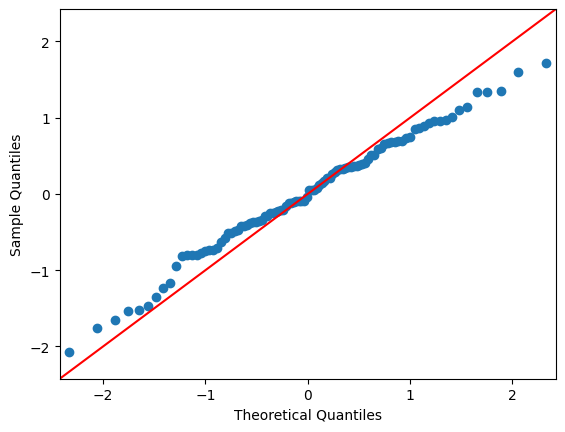

In [12]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(treatment_data['hours_taken'] - treatment_mean, line='45')
plt.show()



### Box cox transformation to normalize data

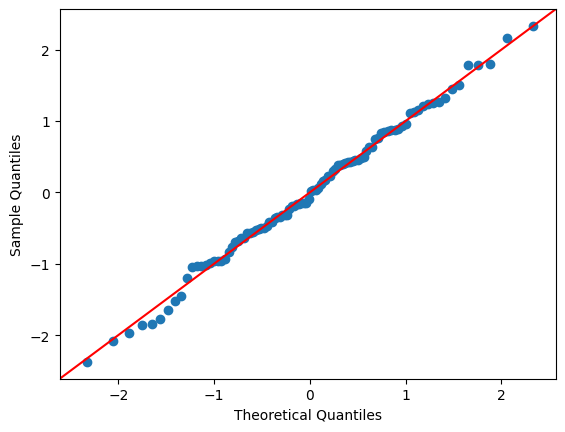

In [13]:
from scipy import stats

xt, _ = stats.boxcox(treatment_data['hours_taken'])
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(xt - xt.mean(), line='45')
plt.show()

## T-test for an A/b Test

In [5]:
# Perform t-test  using scipy.stats
t_stat, p_value = stats.ttest_ind(control_data['hours_taken'], treatment_data['hours_taken'], equal_var=False)

# Display results
print(f'T-Statistic: {t_stat}')
print(f'P-Value: {p_value}')

T-Statistic: 2.8648127755484127
P-Value: 0.004624258680027422


Step 5: Interpret Results
The p-value will tell you whether the change in the IR system significantly impacts the number of hours taken by maintenance engineers to find information.

A small p-value (typically ≤ 0.05) indicates that you can reject the null hypothesis. This would mean the new system has a statistically significant effect on reducing the time taken.
A large p-value (> 0.05) indicates that you fail to reject the null hypothesis, meaning no significant difference exists.
Step 6: Make Business Decisions
Use these statistical insights, along with other considerations like implementation costs or user satisfaction, to make a decision about whether the new system is effective and should be fully implemented.

This framework gives you a good starting point for performing A/B tests focused on continuous outcomes using Python. It's important to ensure that your sample sizes are large enough to detect a meaningful difference and that you've considered other potential confounding variables that could affect the results.

## Power analysis - ensuring the sample sizes are large enough for the statistical test

In [10]:
from statsmodels.stats.power import TTestIndPower

# Parameters
effect_size = 0.3  # Assumed effect size based on domain knowledge or a pilot study
alpha = 0.05  # Significance level
power = 0.8  # Power

# Perform power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
print(f'Required sample size: {round(sample_size)} per group')

Required sample size: 175 per group


### then once the experiment is done we can calculate the observed power

In [13]:
## Measure the observed effect size

# The observed effect size is a way to quantify the difference between two groups in standardized terms, and it's essential for post-hoc power analysis. For a two-sample t-test, Cohen's d is commonly used as the measure of effect size. 

# d = (x̄1 - x̄2) / pool standard deviation

import numpy as np

# Calculate sample means
mean_control = control_data['hours_taken'].mean()
mean_treatment = treatment_data['hours_taken'].mean()

# Calculate sample standard deviations
std_control = control_data['hours_taken'].std()
std_treatment = treatment_data['hours_taken'].std()

# Calculate sample sizes
n_control = len(control_data)
n_treatment = len(treatment_data)

# Calculate pooled standard deviation
std_pooled = np.sqrt(((n_control - 1) * std_control ** 2 + (n_treatment - 1) * std_treatment ** 2) / (n_control + n_treatment - 2))

# Calculate Cohen's d
observed_effect_size = (mean_control - mean_treatment) / std_pooled

observed_effect_size

0.40514570808402744

In [14]:
# Assume observed_effect_size and actual_sample_size are calculated from your data
#observed_effect_size = ...  # Replace with your value
#actual_sample_size = ...  # Replace with your value

actual_sample_size = control_data.shape[0]

# Calculate observed power
observed_power = analysis.solve_power(effect_size=observed_effect_size, nobs1=actual_sample_size, alpha=alpha)
print(f'Observed power: {observed_power}')

Observed power: 0.8135165452693741


## MLE approach

In [51]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

In [52]:
def neg_log_likelihood(params, data):
    mu, sigma = params
    return -np.sum(norm.logpdf(data, mu, sigma))

In [59]:
# Initial parameter guess [mu, sigma]
initial_params = [3, 1]

# MLE for Control Group
result_control = minimize(neg_log_likelihood, initial_params, args=(control_data['hours_taken']))
mu_control, sigma_control = result_control.x

# MLE for Treatment Group
result_treatment = minimize(neg_log_likelihood, initial_params, args=(treatment_data['hours_taken']))
mu_treatment, sigma_treatment = result_treatment.x

print(f'Control group parameters: mu = {mu_control}, sigma = {sigma_control}')
print(f'Treatment group parameters: mu = {mu_treatment}, sigma = {sigma_treatment}')

Control group parameters: mu = 3.0376130439882467, sigma = 1.034631875405075
Treatment group parameters: mu = 2.771982923167568, sigma = 0.7807140558051618


Step 4: A/B Test and Interpretation
Now that you have estimates of the distribution parameters for both groups, you can:

Simulate what the distributions should look like based on these parameters.
Conduct hypothesis tests based on the estimated distributions.
Calculate confidence intervals for the estimated parameters.
Analyze how different the parameters of the two distributions are to understand the effect of the change (treatment).
This approach allows for more nuanced analyses compared to the classical t-test, especially when the underlying distributions are not normal or when they differ in shape.

### Confidence intervals for the MLE approach

In [60]:
# Number of samples
n_control = len(control_data['hours_taken'])
n_treatment = len(treatment_data['hours_taken'])

# Calculate the Fisher Information Matrix for Control and Treatment groups
fisher_info_matrix_control = np.array([[n_control / sigma_control**2, 0], [0, n_control / (2 * sigma_control**2)]])
fisher_info_matrix_treatment = np.array([[n_treatment / sigma_treatment**2, 0], [0, n_treatment / (2 * sigma_treatment**2)]])

# Calculate the standard errors by taking the square root of the diagonal elements
# from the inverse of the Fisher Information Matrix
se_mu_control, se_sigma_control = np.sqrt(np.linalg.inv(fisher_info_matrix_control).diagonal())
se_mu_treatment, se_sigma_treatment = np.sqrt(np.linalg.inv(fisher_info_matrix_treatment).diagonal())

# Calculate the 95% Confidence Intervals
conf_interval_mu_control = [mu_control - 1.96 * se_mu_control, mu_control + 1.96 * se_mu_control]
conf_interval_sigma_control = [sigma_control - 1.96 * se_sigma_control, sigma_control + 1.96 * se_sigma_control]

conf_interval_mu_treatment = [mu_treatment - 1.96 * se_mu_treatment, mu_treatment + 1.96 * se_mu_treatment]
conf_interval_sigma_treatment = [sigma_treatment - 1.96 * se_sigma_treatment, sigma_treatment + 1.96 * se_sigma_treatment]

print(f"95% CI for mu (Control): {conf_interval_mu_control}")
print(f"95% CI for sigma (Control): {conf_interval_sigma_control}")
print(f"95% CI for mu (Treatment): {conf_interval_mu_treatment}")
print(f"95% CI for sigma (Treatment): {conf_interval_sigma_treatment}")

95% CI for mu (Control): [2.834825196408852, 3.240400891567641]
95% CI for sigma (Control): [0.747846551073847, 1.321417199736303]
95% CI for mu (Treatment): [2.6189629682297566, 2.9250028781053796]
95% CI for sigma (Treatment): [0.5643111602183887, 0.997116951391935]


### compare confidence intervals of means

In [63]:
from scipy import stats
import numpy as np

# Generate synthetic data
np.random.seed(0)
group1 = control_data['hours_taken']  # np.random.normal(50, 10, 100)  # control group
group2 = treatment_data['hours_taken']  # np.random.normal(55, 10, 100)  # treatment group

# Calculate the means and standard deviations
mean1, mean2 = np.mean(group1), np.mean(group2)
std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

# Sample sizes
n1, n2 = len(group1), len(group2)

# Calculate standard errors
se1, se2 = std1 / np.sqrt(n1), std2 / np.sqrt(n2)

# Z-score for 95% confidence
z_score = stats.norm.ppf(0.975)

# Confidence intervals
ci1 = [mean1 - z_score * se1, mean1 + z_score * se1]
ci2 = [mean2 - z_score * se2, mean2 + z_score * se2]

print(f"Group1 CI: {ci1}")
print(f"Group2 CI: {ci2}")

Group1 CI: [2.833807349633719, 3.2414187719038483]
Group2 CI: [2.6181949036478027, 2.925770935544194]


# Bootstrap

Using Bootstrap to Calculate Confidence Intervals and compare two groups. Can be used when the data is not normally distributed.

In [19]:
import numpy as np

# Generate synthetic data
np.random.seed(0)

group1 = control_data['hours_taken']  
group2 = treatment_data['hours_taken']  

# Bootstrapping
n_iterations = 1000
bootstrap_means1 = np.zeros(n_iterations)
bootstrap_means2 = np.zeros(n_iterations)

for i in range(n_iterations):
    bootstrap_sample1 = np.random.choice(group1, size=len(group1), replace=True)
    bootstrap_sample2 = np.random.choice(group2, size=len(group2), replace=True)
    bootstrap_means1[i] = np.mean(bootstrap_sample1)
    bootstrap_means2[i] = np.mean(bootstrap_sample2)

# Confidence intervals
ci1 = np.percentile(bootstrap_means1, [2.5, 97.5])
ci2 = np.percentile(bootstrap_means2, [2.5, 97.5])

print(f"Group1 CI: {ci1}")
print(f"Group2 CI: {ci2}")

Group1 CI: [1. 1.]
Group2 CI: [0. 0.]


In [ ]:
alpha and beta -- plot to show significance for the t-test
    
    for improvement in accuracy of score of exam we see decrease in confidence interval (less variance) and the location to be lower (less time spent)

